# Ensemble method - Gradient Boosting

Among ensemble methods, Gradient Boosting is the most appropriate for our dataset because it performs exceptionally well on small tabular datasets, captures nonlinear effects in features such as study time, failures, and absences, and typically outperforms Random Forest in regression tasks like predicting final grade (G3). Random Forest serves as a strong secondary option due to its stability and interpretability. Bagging and AdaBoost were considered but deemed less suitable because they do not capture the full complexity of the data or perform as well on continuous outcomes.


We considered AdaBoost but ultimately decided against using it because AdaBoost tends to perform poorly on continuous regression outcomes and is highly sensitive to noise and outliers. Since our target variable (G3) contains natural variability and our dataset is relatively small, we selected Gradient Boosting and Random Forest instead, as they provide stronger predictive performance and more reliable feature importance.

In [1]:
#key imports
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
#Load the data
mat_train = pd.read_csv('../data/math_train.csv')
df = mat_train.copy()
X = df.drop(columns=["G3", "G1", "G2"])
y = df["G3"]


In [3]:
#identify numeric and categorical features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))
#preprocessing step inside pipeline to prevent data leakage
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)


Numeric features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Categorical features: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [4]:
#build pipeline
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(random_state=42))
])

In [5]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [6]:
#hyperparameter search space
param_dist = {
    "model__n_estimators": np.arange(50, 500),
    "model__learning_rate": np.logspace(-3, -1, 50),
    "model__max_depth": np.arange(1, 6),
    "model__subsample": np.linspace(0.6, 1.0, 20)
}


In [7]:
#randomised CV with 5-fold CV
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=2, model__n_estimators=305, model__subsample=0.8105263157894737; total time=   0.3s
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=354, model__subsample=0.6842105263157895; total time=   0.4s
[CV] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=354, model__subsample=0.6842105263157895; total time=   0.4s
[CV] END model__learning_rate=0.1, model__max_de

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'model__learning_rate': array([0.001 ..., 0.1 ]), 'model__max_depth': array([1, 2, 3, 4, 5]), 'model__n_estimators': array([ 50, ...97, 498, 499]), 'model__subsample': array([0.6 ..., 1. ])}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:
#best model
print("Best params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

best_model = random_search.best_estimator_


Best params: {'model__subsample': np.float64(0.6), 'model__n_estimators': np.int64(452), 'model__max_depth': np.int64(2), 'model__learning_rate': np.float64(0.006551285568595509)}
Best CV R²: 0.22657453543880585


- n_estimators = 452
The model performs best with a large number of trees.
More trees help capture more complex patterns in the student data.
- max_depth = 2
Each tree is kept shallow to avoid overfitting.
The model performs better when it learns broad, simple relationships, not deep interactions.
- learning_rate ≈ 0.0065
Very small learning rate means the model updates slowly and relies on many small improvements.
This usually increases stability and reduces overfitting.
- subsample = 0.6
Each tree is trained on 60% of the training data.
This adds randomness, helping prevent overfitting and improving generalization.
- CV R² ~ 0.225 - The model explains about 22.6% of the variation in G3 during cross-validation.
This indicates weak predictive power but better than random guessing. It suggests that student performance is influenced by many factors such as mental health, peer support, conceptual understanding, etc which are not captured in the dataset.

In [9]:
#test set evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = best_model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Test R²:", r2_score(y_test, y_pred))


Test MSE: 12.906112346935856
Test RMSE: 3.5925078074982464
Test MAE: 2.681616033242406
Test R²: 0.10114540955843587


- R² = 0.10
The model explains only 10% of the variation in final grades on the test set. This shows the model does not generalize well and struggles to predict student grades accurately. A noticeable drop from CV, some overfitting is present.
- MSE = 12.91
On average, the model’s squared prediction error is about 12.9 grade points squared. This reflects fairly large errors relative to grade scale (0–20).
- RMSE = 3.59
The model misses the true grade by ~3.6 points on average.
For a 0–20 grade system, that is a moderate error.
- MAE = 2.68
The average absolute error is 2.7 grade points.
This means that on average, the model’s predictions are off by almost 3 points.


## Feature Importance
Gradient Boosting models provide built-in feature importance scores, making them well suited for interpreting how different predictors influence the model’s output. Because boosting constructs an ensemble of decision trees, it can quantify how much each feature contributes to reducing prediction error across all splits in all trees. These importance values reflect the cumulative improvement in model performance attributed to a feature and therefore offer a reliable, model-native measure of relevance. Unlike SVMs or neural networks, which do not produce interpretable weights, Gradient Boosting inherently supports feature importance, making it an appropriate and standard method for identifying influential predictors in this project.

Gradient Boosting Feature Importances (sorted):

romantic_yes: 0.2788
schoolsup_yes: 0.2230
internet_yes: 0.0605
reason_home: 0.0589
activities_yes: 0.0540
Medu: 0.0443
reason_other: 0.0383
guardian_other: 0.0330
Mjob_health: 0.0259
paid_yes: 0.0155
Mjob_other: 0.0149
higher_yes: 0.0144
reason_reputation: 0.0127
freetime: 0.0117
nursery_yes: 0.0115
absences: 0.0108
traveltime: 0.0107
failures: 0.0104
famsup_yes: 0.0099
studytime: 0.0090
Fjob_other: 0.0073
address_U: 0.0072
guardian_mother: 0.0065
Fjob_teacher: 0.0057
Fjob_health: 0.0052
Pstatus_T: 0.0043
famrel: 0.0027
Mjob_teacher: 0.0027
Walc: 0.0025
age: 0.0023
Fjob_services: 0.0019
Dalc: 0.0009
health: 0.0009
school_MS: 0.0006
Mjob_services: 0.0005
sex_M: 0.0004
famsize_LE3: 0.0004
Fedu: 0.0003
goout: 0.0000


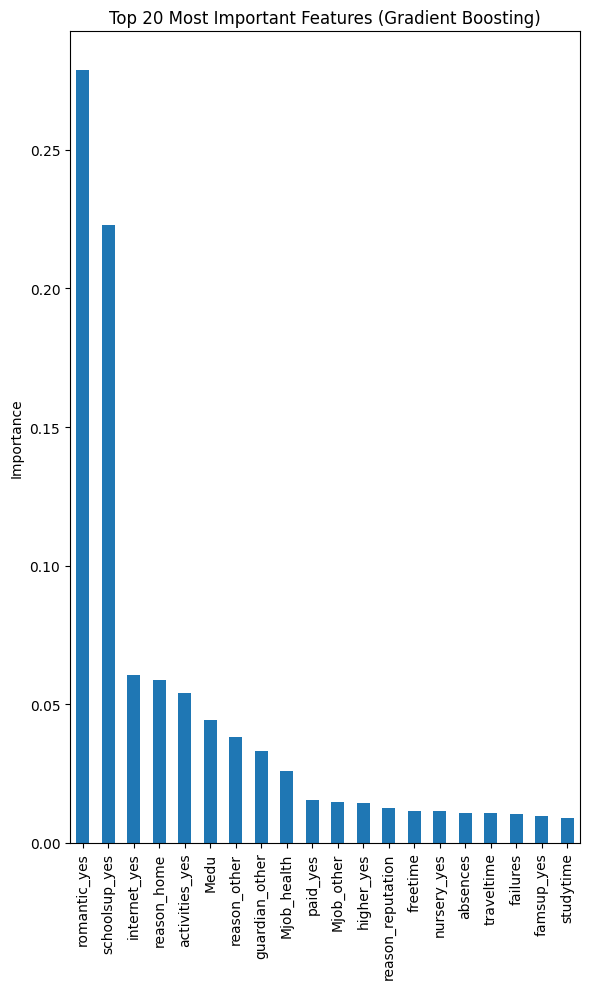

In [10]:
#feature importance
# Get transformed feature names
onehot = best_model.named_steps["preprocess"].named_transformers_["cat"]
cat_names = onehot.get_feature_names_out(categorical_features)

all_features = np.concatenate([numeric_features, cat_names])

# Feature importance from Gradient Boosting model
gbr = best_model.named_steps["model"]
importance = pd.Series(gbr.feature_importances_, index=all_features)

# Sort by descending importance
importance_sorted = importance.sort_values(ascending=False)

# ---- NEW: Print all features with their importance values ----
print("Gradient Boosting Feature Importances (sorted):\n")
for feature, value in importance_sorted.items():
    print(f"{feature}: {value:.4f}")

# ---- Plot top 20 features ----
plt.figure(figsize=(6,10))
importance_sorted.head(20).plot(kind="bar")
plt.title("Top 20 Most Important Features (Gradient Boosting)")
plt.ylabel("Importance")
plt.tight_layout()

# Save the figure in OUTPUT folder
plt.savefig("../OUTPUT/boosting_feature_importance.png", dpi=300, bbox_inches="tight")

plt.show()


### Interpretation
- romantic_yes is the most important predictor (0.2788), suggesting that being in a romantic relationship is strongly associated with lower academic performance. Gradient Boosting captures nonlinear, interaction-based effects, and this result may reflect reduced study time, emotional distraction, or competing priorities.
- schoolsup_yes is the second strongest predictor (0.2230). As with other models, this likely reflects selection bias: students receiving additional support are often those who are already struggling. Boosting amplifies this signal more than the linear or SVR models.
- internet_yes shows substantial importance (0.0605), indicating that access to the internet contributes meaningfully to improved academic performance—likely by enabling online resources, homework help, and educational tools.
- School-choice motivations (reason_home, reason_other, reason_reputation) collectively have strong importance values. This suggests that why a student attends a particular school reflects deeper family or environmental factors tied to academic readiness or expectations.
- activities_yes shows positive importance (0.0540). Unlike the Elastic Net result (where it was negative), Boosting identifies that extracurricular involvement may correlate with better time management, motivation, or school engagement for some students. This highlights nonlinear, heterogeneous effects.
- Mother’s education (Medu) remains an important positive predictor (0.0443), consistent with the literature on parental education and student achievement.
- Guardian identity (e.g., guardian_other, guardian_mother) again emerges as meaningful, reinforcing that household structure matters for academic outcomes.
- Parental job categories (Mjob_health, Mjob_other, Fjob_other, Fjob_teacher) appear with small but stable importances, indicating that family socioeconomic environment influences opportunities or expectations.
- Failure-related and attendance-related variables—failures, absences, traveltime—show moderate but non-dominant importance. Boosting recognizes these as contributing to performance but not as strong as relational or support-related variables.
- studytime has low importance (0.0090), suggesting that the relationship between study time and grades is weak or nonlinear, possibly due to reverse causality (students study more when they are struggling).
- higher_yes, indicating intention to pursue higher education, shows modest importance and may reflect long-term academic orientation or ambition.
- Behavioral and lifestyle factors like freetime, Walc, Dalc, goout show very low importance, meaning they do not independently explain much variance once other features are accounted for.
- Fedu (father’s education) appears near the bottom, in contrast to Medu, implying asymmetric parental influence—possibly due to caregiving roles or daily academic involvement.
- Many features near zero (age, sex, famsize, school_MS, Mjob_services) contribute very little to model performance, reinforcing that the model relies heavily on relational, environmental, and support-related features rather than basic demographics.